<a href="https://colab.research.google.com/github/shohan007/time-series-analysis/blob/main/Time_series_deltaP_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 8.0 MB/s 
     |████████████████████████████████| 9.8 MB 15.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#For deltaP

In [ ]:
#Data preprocessing
dp_dataset=pd.read_excel ('/content/Namrc paper DIS data.xlsx',sheet_name='deltaP',index_col=0)
dp_dataset.head(10)

,Design,DeltaP
Serial,,
1,1,1.506
2,1,1.273
3,1,1.384
4,1,1.516
5,1,1.428
6,1,1.572
7,1,1.413
8,1,1.682
9,1,1.558


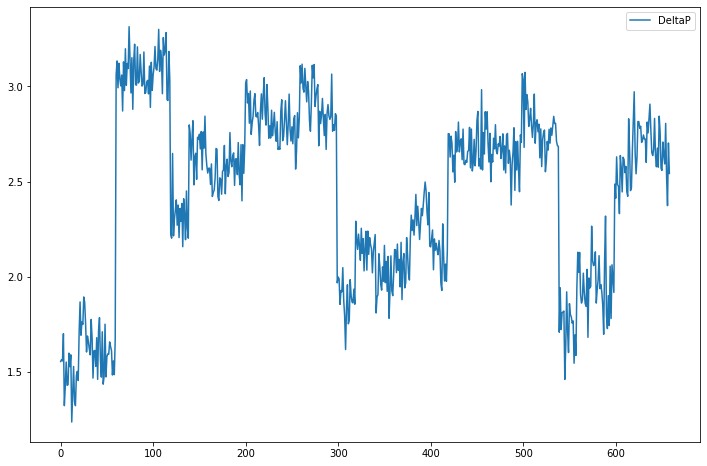

In [ ]:
Group=4


dp_group_current=dp_dataset[dp_dataset['Design']==Group]
dp_group_current.head()

dp_group_current=dp_group_current.drop(columns=['Design'])
dp_group_current.reset_index(inplace=True,drop=True)
dp_group_current.plot(figsize=(12,8))


In [ ]:
#Automate the augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

adf_test(dp_group_current['DeltaP'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.210016
p-value                   0.019412
# lags used               2.000000
# observations          656.000000
critical value (1%)      -3.440358
critical value (5%)      -2.865956
critical value (10%)     -2.569122
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
#Split the data into train/test sets
# last two day for testing
train = dp_group_current.iloc[:540]
test = dp_group_current.iloc[540:]

start=541
end=659


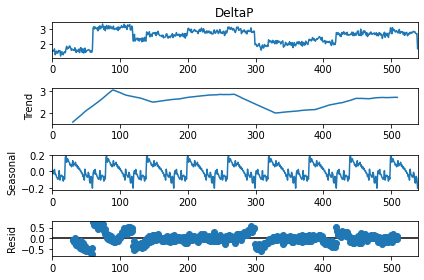

In [ ]:
#checking additive vs multiplicative
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = train['DeltaP']
result = seasonal_decompose(series, model='add', period=60)
result.plot()
pyplot.show()

##Exponential Smoothing

Exponential Smoothing MSE Error: 0.1446904188


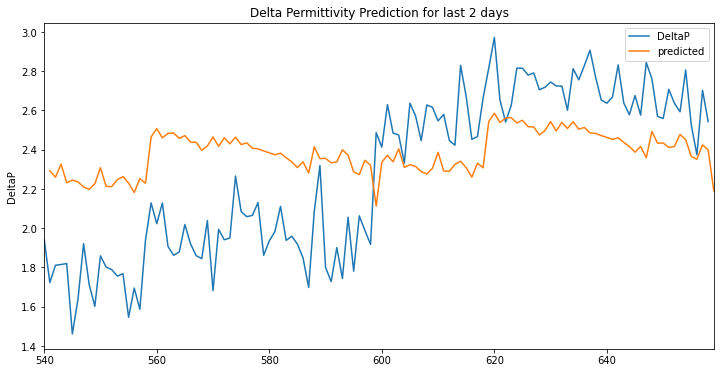

In [ ]:
#fit the exponential smoothing
import statsmodels.tsa.arima.model as stats
from statsmodels.tsa.api import ExponentialSmoothing

results = ExponentialSmoothing(train['DeltaP'],trend='add',seasonal='add',seasonal_periods=60)
results_fit=results.fit()

#predict last 2 days
predictions = results_fit.predict(start=start, end=end)

predictions=pd.DataFrame(predictions, columns=['predicted'])

# Compare predictions to expected values
#for i in range(start+1,end):
#    print(f"predicted={predictions['predicted'][i]}, expected={test['DeltaP'][i]}")

#Plot predictions against known values

title = 'Delta Permittivity Prediction for last 2 days'
ylabel='DeltaP'
xlabel='' # we don't really need a label here

ax = test['DeltaP'].plot(legend=True,figsize=(12,6),title=title)
predictions['predicted'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#Evaluate

from statsmodels.tools.eval_measures import rmse

error = rmse(test['DeltaP'], predictions['predicted'])
#print(f'Exponential Smoothing RMSE Error: {error:11.10}')

from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['DeltaP'], predictions['predicted'])
print(f'Exponential Smoothing MSE Error: {error:11.10}')

##ARMA Model

In [ ]:
# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

#Determine the (p,q) ARMA Orders using pmdarima.auto_arima
auto_arima(train['DeltaP'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  540
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 212.184
Date:                Wed, 24 Nov 2021   AIC                           -420.368
Time:                        05:47:09   BIC                           -411.788
Sample:                             0   HQIC                          -417.012
                                - 540                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4068      0.023    -17.964      0.000      -0.451      -0.362
sigma2         0.0266      0.001     47.886      0.000       0.026       0.028
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              6060.21
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
import statsmodels.tsa.arima.model as stats
model = stats.ARIMA(train['DeltaP'], order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 DeltaP   No. Observations:                  540
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 212.184
Date:                Wed, 24 Nov 2021   AIC                           -420.368
Time:                        05:47:23   BIC                           -411.788
Sample:                             0   HQIC                          -417.012
                                - 540                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4068      0.023    -17.964      0.000      -0.451      -0.362
sigma2         0.0266      0.001     47.886      0.000       0.026       0.028
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              6060.21
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARMA MSE Error: 0.1926010257


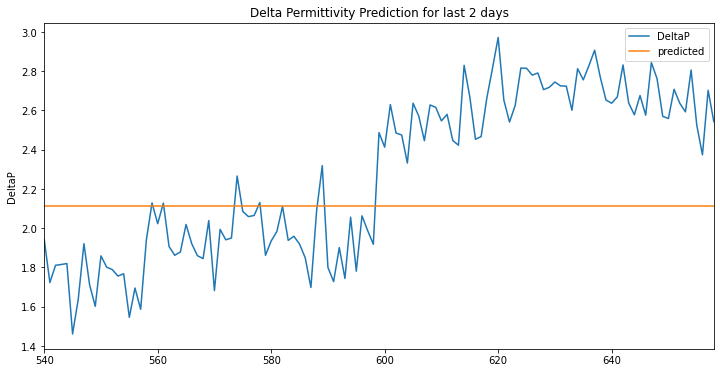

In [ ]:
#Obtain two days worth of predicted values

predictions = results.predict(start=start, end=end).rename('predicted')

predictions=pd.DataFrame(predictions)
predictions.set_index(test.index, inplace=True)


#Plot predictions against known values

title = 'Delta Permittivity Prediction for last 2 days'
ylabel='DeltaP'
xlabel='' # we don't really need a label here

ax = test['DeltaP'].plot(legend=True,figsize=(12,6),title=title)
predictions['predicted'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#Evaluate

from statsmodels.tools.eval_measures import rmse

error = rmse(test['DeltaP'], predictions['predicted'])
#print(f'ARMA RMSE Error: {error:11.10}')

from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['DeltaP'], predictions['predicted'])
print(f'ARMA MSE Error: {error:11.10}')

##ARIMA MODEL

In [ ]:
#Use pmdarima.auto_arima to determine ARIMA Orders
auto_arima(train['DeltaP'],seasonal=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  540
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 212.184
Date:                Wed, 24 Nov 2021   AIC                           -420.368
Time:                        05:47:47   BIC                           -411.788
Sample:                             0   HQIC                          -417.012
                                - 540                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4068      0.023    -17.964      0.000      -0.451      -0.362
sigma2         0.0266      0.001     47.886      0.000       0.026       0.028
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              6060.21
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
import statsmodels.tsa.arima.model as stats
model = stats.ARIMA(train['DeltaP'],order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 DeltaP   No. Observations:                  540
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 212.184
Date:                Wed, 24 Nov 2021   AIC                           -420.368
Time:                        05:49:08   BIC                           -411.788
Sample:                             0   HQIC                          -417.012
                                - 540                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4068      0.023    -17.964      0.000      -0.451      -0.362
sigma2         0.0266      0.001     47.886      0.000       0.026       0.028
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              6060.21
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA RMSE Error: 0.4388633338
ARIMA MSE Error: 0.1926010257


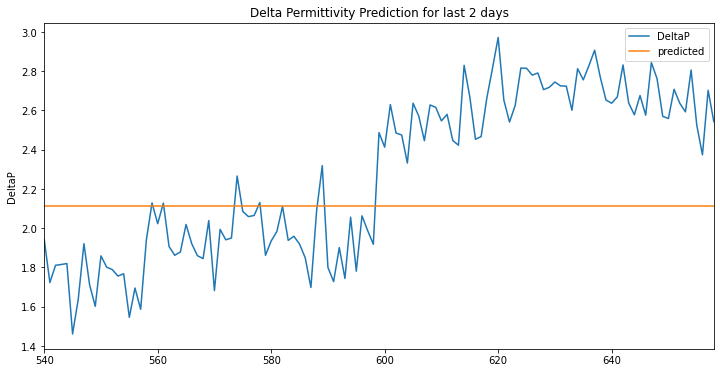

In [ ]:
#Obtain two days worth of predicted values

predictions = results.predict(start=start, end=end).rename('predicted')

predictions=pd.DataFrame(predictions)
predictions.set_index(test.index, inplace=True)


#Plot predictions against known values

title = 'Delta Permittivity Prediction for last 2 days'
ylabel='DeltaP'
xlabel='' # we don't really need a label here

ax = test['DeltaP'].plot(legend=True,figsize=(12,6),title=title)
predictions['predicted'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#Evaluate

from statsmodels.tools.eval_measures import rmse

error = rmse(test['DeltaP'], predictions['predicted'])
print(f'ARIMA RMSE Error: {error:11.10}')

from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['DeltaP'], predictions['predicted'])
print(f'ARIMA MSE Error: {error:11.10}')

#SARIMAX Model

In [ ]:
# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# For SARIMA Orders we set seasonal=True and pass in an m value
#auto_arima(df['DeltaP'],seasonal=True,m=20).summary()

In [ ]:
#Fit SarimaX
model = SARIMAX(train['DeltaP'],order=(0,1,1),seasonal_order=(0,1,1,60))   #G1-(0,1,1)(2,1,1,60)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             DeltaP   No. Observations:                  540
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 60)   Log Likelihood                 130.204
Date:                            Wed, 24 Nov 2021   AIC                           -254.407
Time:                                    05:51:00   BIC                           -241.892
Sample:                                         0   HQIC                          -249.487
                                            - 540                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4170      0.027    -15.188      0.000      -0.471      -0.363
ma.S.L60      -0.9974      4.654     -0.214      0.830     -10.119       8.124
sigma2         0.0258      0.120      0.215      0.829      -0.209       0.261
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              3252.54
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -1.47
Prob(H) (two-sided):                  0.06   Kurtosis:                        15.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA RMSE Error: 0.380212078
SARIMA MSE Error: 0.1445612243


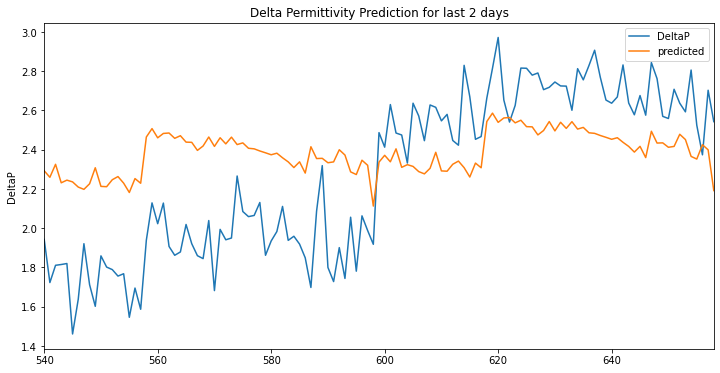

In [ ]:
#Obtain two days worth of predicted values

predictions = results.predict(start=start, end=end).rename('predicted')

predictions=pd.DataFrame(predictions)
predictions.set_index(test.index, inplace=True)


#Plot predictions against known values

title = 'Delta Permittivity Prediction for last 2 days'
ylabel='DeltaP'
xlabel='' # we don't really need a label here

ax = test['DeltaP'].plot(legend=True,figsize=(12,6),title=title)
predictions['predicted'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#Evaluate

from statsmodels.tools.eval_measures import rmse

error = rmse(test['DeltaP'], predictions['predicted'])
print(f'SARIMA RMSE Error: {error:11.10}')

from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['DeltaP'], predictions['predicted'])
print(f'SARIMA MSE Error: {error:11.10}')

##SVM

In [ ]:
T = 10

In [ ]:
# make supervised dataset
# build the dataset

def make_supervised_dataset(series):

    X = []
    Y = []

    for t in range(len(series) - T):  # will go upto 989 inclusive
        X.append(series[t:t + T])
        Y.append(series[t + T])

    N = len(X)
    X = np.array(X).reshape((-1, T))
    Y = np.array(Y)
    print(f"[INFO] shape of X: {X.shape} and Y: {Y.shape}......")
    return X, Y, N

X, y, N = make_supervised_dataset(dp_group_current['DeltaP'])

[INFO] shape of X: (649, 10) and Y: (649,)......


In [ ]:
X=pd.DataFrame(X)
y=pd.DataFrame(y)

#Training Test split

X_train=X.iloc[1:-120,:].values
y_train=y.iloc[1:-120,:].values             #last 10 row test and prediction data
X_test=X.iloc[X_train.shape[0]:,:].values
y_test=y.iloc[y_train.shape[0]:,:].values  
y_train_df=y.iloc[1:-120,:] #making dataframe for using in graph
y_test_df=y.iloc[y_train.shape[0]:,:] #making dataframe for using in graph

#Hyper Parameter Tuning with cross validation

parameters = {'kernel':['linear', 'rbf'],'C':[0.1, .5, 1, 5, 10], 'epsilon':[0.01, 0.1,0.2,0.5,1], 'gamma': [ 0.001, 0.001, 0.1, 0.5, 1, 5]}
# Create a based model
svr = SVR()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = svr, param_grid = parameters, scoring='neg_root_mean_squared_error',
                          cv = 5, n_jobs = -1)

grid_search.fit(X_train, y_train)
#grid_search.best_params_
print(grid_search.best_estimator_)

# Generate predictions for testing data
y_pred = grid_search.predict(X_test)

#prediction of test data
predictions_y=pd.DataFrame(y_pred)
predictions_y.set_index(y_test_df.index, inplace=True)
predictions_y.rename(columns={0: 'Predicted_DeltaP'}, inplace=True)
#y_test_df.head()  

#predictions_y
#predictions_y.head()

#predictions of training data
x_pred=grid_search.predict(X_train)
predictions_x=pd.DataFrame(x_pred)

#predictions_x.head()

# Calculate the root mean square error (RMSE), normalized root mean square error (nRMSE) for test and training data
N = len(y_test)
mse_test=np.sum((np.array(y_test_df).flatten() - (np.array(predictions_y).flatten()))**2)/N
rmse_test = np.sqrt(np.sum((np.array(y_test_df).flatten() - (np.array(predictions_y).flatten()))**2)/N)
nRMSE_test=rmse_test/(np.array(y_test_df).max()-np.array(y_test_df).min())
 

print("MSE Test: ", mse_test)    
print("RMSE Test: ", rmse_test) 


SVR(C=0.5, epsilon=0.2, gamma=0.001, kernel='linear')
MSE Test:  0.034359617131287615
RMSE Test:  0.18536347302337539


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
